*The codes were developed on Windows 10, and were not tested on other machines. Anaconda 5.2.0 is chosen as a Python interpreter.*

This notebook introduces the concept and methodology of implementing Bootstrap Simulation.

# Bootstrap Simulation

> **Bootstrap Simulation** is a non-parametric statistical technique to resample from known samples to estimate uncertainty in summary statistics. When there are small, limited number of samples, it gives a more accurate forecast model than directly obtaining a forecast model from the limited sample pool. It is non-parametric because it does not require any prior knowledge of the distribution (shape, mean, standard devation, etc..).

One goal of inferential statistics is to determine the value of a parameter of an entire population. It is typically too expensive or even impossible to measure this directly. So we use statistical sampling. We sample a population, measure a statistic of this sample, and then use this statistic to say something about the corresponding parameter of the population.

Bootstrapping is a type of resampling method to save time and money taking measurements. It picks a random value from a sample pool N times **with replacement**, and create M number of new Bootstrapped-sample pools. The term **with replacement** here means that you put back the sample you drew to the original sample pool after adding it to a new Bootstrapped-sample pool. Thick of it this way: you randomly choose a file from a folder in your PC, and you *copy* and paste the randomly-chosen file into a new folder. You do not *cut* and paste the file, but you *copy* and paste file into a new folder. You will have M number of folders, each containing N number of files.

Bootstrapping is used for three reasons:

1. Bootstrap can obtain confidence interval in any statistics.
2. Bootstrap does not assume anything about a distribution.
3. Bootstrap helps when there are to few number of samples.

** imports **

In [61]:
import re
import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
%matplotlib notebook

## 1. Confidence Interval in Population Parameters: US Height Example

Bootstrap simulation can be run to obtain confidence intervals in various population parameters: mean, stdev, variance, min, or max. In this example, we will assume a scenario in which we know the distribution of a population. 

### 1.1 Initial Data From the US Census Bureau

From the U.S. Census Bureau, you obtained the mean and standard deviation values for the US males and females height. The distribution is Gaussian, and the statistics are as follows:

In [12]:
census_data = pd.DataFrame(data=[[69.7, 64.3], [2.9, 2.6]], columns=['Male (inches)', 'Female (inches)'], index=['mean', 'stdev'])
census_data

,Male (inches),Female (inches)
mean,69.7,64.3
stdev,2.9,2.6


### 1.2 Random Sampling Through Monte-Carlo Simulation 

Based on the mean and standard deviation values of the Gaussian weight distribution, [Monte-Carlo Simulation](https://nbviewer.jupyter.org/github/aegis4048/Petroleum_Engineering/blob/master/Data%20Analysis/Uncertainty%20Modeling%20with%20Monte-Carlo%20Simulation.ipynb) can be run to generate random samples. 

<div class="alert alert-info">
    <h4>Notes:</h4> 
    <p>In this scenario, <b>Monte-Carlo simulation</b> is used to perform random sampling, because we have only the mean and standard deviation values of the population. Currently there are no samples. Since <b>Bootstrap random sampling</b> is resampling from a sample pool, without the existence of a sample pool, Bootstrap random sampling can't be done.</p>
</div>

** Simulate Random Samples **

In [52]:
monte_iter = 100

male = np.random.normal(census_data['Male (inches)']['mean'], census_data['Male (inches)']['stdev'], monte_iter)
female = np.random.normal(census_data['Female (inches)']['mean'], census_data['Female (inches)']['stdev'], monte_iter)

monte_data = pd.DataFrame([male, female], index=['Male (inches)', 'Female (inches)']).T

** Visualize **

In [81]:
def visualize(dataframe):
    labels = list(map(lambda x: re.sub(" \(.*?\)", "", x), dataframe.columns))
    dataframe = dataframe.apply(lambda x: x.sort_values().values)
    f, ax = plt.subplots()
    
    for col, label in zip(dataframe, labels):
        fit = stats.norm.pdf(dataframe[col], np.mean(dataframe[col]), np.std(dataframe[col]))
        ax.plot(dataframe[col], fit, '-o', label=label,)
    ax.legend()
    ax.set_ylabel('Probability')
    return ax

<IPython.core.display.Javascript object>


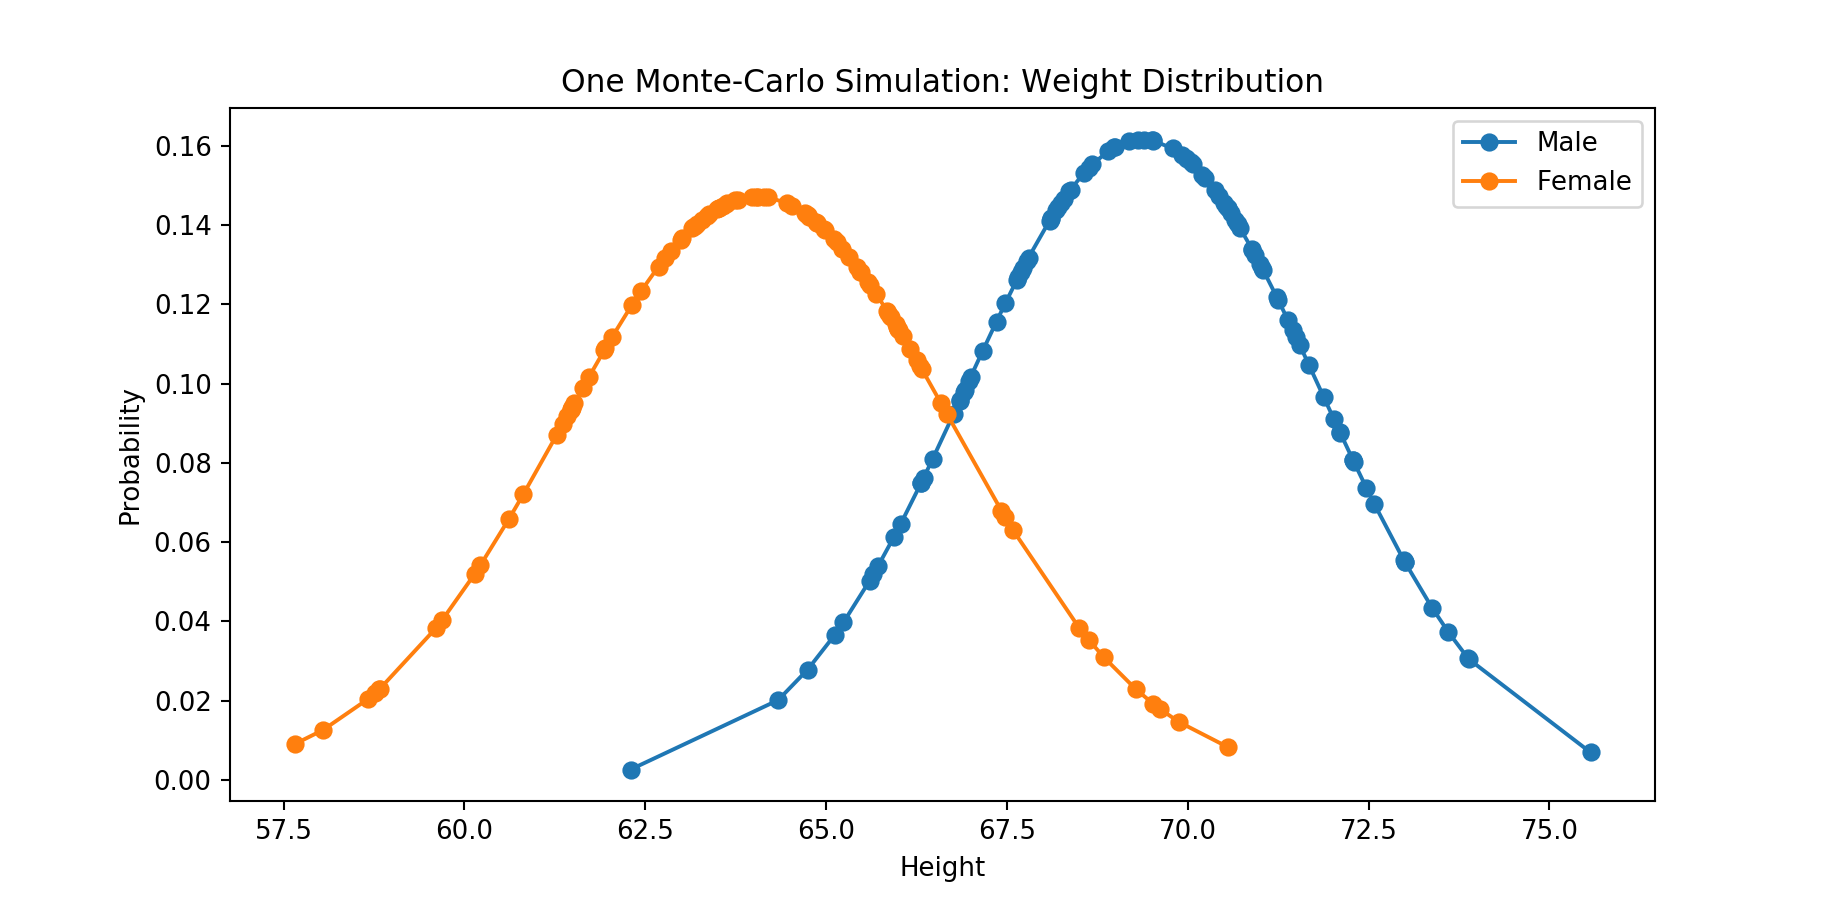

In [88]:
ax = visualize(monte_data)
ax.set_xlabel('Height')
ax.set_title('One Monte-Carlo Simulation: Weight Distribution');

<p><center><b>Bootstrap can obtain confidence interval in any statistics</b></center></p>

It can provide confidence interval in virtually any statistical values (mean, standard deviation, skewness, kurtosis, etc..), when the formula to calculate them is unknown. Let's assume that you want to obtain an uncertainty model for the weights of 5th-grade students in a region. If you know the weight distribution of the students from some type of a government statistic report, you can implement *Monte-Carlo Simulation* to generate virtually unlimited number of random samples. This one Monte-Carlo simulation contains N number of random samples, and summary statistics can be drawn from this data. Mean, standard deviation, min, max, P10, or P90 values can be obtained. However, how sure do you feel about these summary statistics? What is the uncertainty in these values? 

For example, from a single Monte-Carlo simulation, you found out that the mean ($\mu$) weight of the US 5th-grade boys is 80 lbs. How can you obtain the uncertainty in the mean weight of the students? The answer is simple: you perform Monte-Carlo simulation hundreds of times, and obtain hundreds of mean values. Since there is a large enough number of mean values, reliable P10 and P90 values can be obtained to draw an uncertainty model for the mean weight of the students. You will end up with something like $\mu$ = 80 $\pm$ 3 lbs.

What if you want to get an uncertainty model for the standard deviation ($\sigma$) of the weight of the students? It's the same: you performn Monte-Carlo simulation hundreds of times, and obtain hundreds of standard deviation values. Then obtain P10 and P90 values of your collection of standard deviations, and draw an uncertainty model for it. You will end up with something like $\sigma$ = 6 $\pm$ 1.3 lbs.

<p><center><b>Bootstrap does not assume anything about the distribution of a population</b></center></p>

Bootstrapping is tied to Monte-Carlo simulation in a sense that it is similar to performing Monte-Carlo simulation many times (recall that Monte-Carlo simulation is performing *random sampling* many times). However, Monte-Carlo simulation requires knowledge about the distribution shape, mean, and standard deviation of the population to generate random samples. What if you do not have any knowledge of those values? 

Bootstrapping is a type of a *resampling* method. You pick a random value from a sample pool N times **with replacement**, and create M number of new Bootstrapped-sample pools. The term **with replacement** here means that you put back the sample you drew to the original sample pool after adding it to a new Bootstrapped-sample pool. Thick of it this way: you randomly choose a file from a folder in your PC, and you *copy* and paste the randomly-chosen file into a new directly. You do not *cut* and paste the file, but you *copy* and paste file. You will end up with N x M matrix of samples, where M is the number of Bootstrap sample pools, and N is the number of random samples in a Bootstrap sample pool.

Because all Bootstrapping is doing is just *resampling* the data by choosing random values from a sample pool, it does not assume anything about the distribution. You do not know to know the distribution parameters of the population to generate random samples.

<p><center><b>Bootstrap can be helpful when there are too few samples</b></center></p>

Ideally, you would want to draw large, non-repeated, samples from a population in order to create a sampling distribution for a statistic. However, you may be limited to one sample because of finances or time. This single sample method can serve as a mini population, from which repeated small samples are drawn with replacement over and over again. As well as saving time and money, bootstrapped samples can be quite good approximations for population parameters.
